In [1]:
import baltic as bt
from matplotlib import pyplot as plt
from collections import defaultdict
from matplotlib import cm
from numpy import linspace
%matplotlib inline
import json
import matplotlib.gridspec as gridspec
import math
from itertools import combinations
import pandas as pd

import numpy as np
import seaborn as sns
from pprint import pprint
import math
import sequtils as sue
from scipy.stats import linregress

sns.set(style='whitegrid', font_scale = 1.2)

In [28]:
# dataset_name = ''
out_path = './'
tree_path = '../data/augur-output/dengue_allBranchEffects_tree.json'
freqs_path = '../data/augur-output/dengue_all_frequencies.json'
reference_path = '../data/reference/genotype_refs_pyke2016.csv'

In [3]:
def assign_genotype_attr(tree, mrcas, trait='genotype'):
    ''' Takes the most basal node with each genotype annotation, 
    propagates the genotype assignment to its monophyletic descendents'''
    
    for k in tree.Objects: # remove old annotations
        k.traits = { key:value for key,value in k.traits.items()
                    if key not in (trait, '%s_mrca'%trait)}
        
    def annotate(genotype, node):
        node.traits['%s_mrca'%trait] = True
        node.traits[trait] = genotype
        for child in tree.traverse_tree(node, include_all=True):
            if trait in child.traits:
                if genotype != child.traits[trait]:
                    print 'ERROR: Overlapping %s trait %s and %s at index %s'%(trait, child.traits[trait], trait, child.index)
            child.traits[trait] = genotype
        
    for genotype, mrca in mrcas.items():
        if isinstance(mrca, list):
            for node in mrca:
                annotate(genotype, node)
        else:
            annotate(genotype, mrca)

    return tree

def load_tree_find_mrcas(path = tree_path):    
    '''Initially, genotype mrcas are as designated by augur.'''
    json_translation = {
        'name': 'strain',
        'height': 'xvalue',
    }
    tree = bt.loadJSON(path, json_translation) ## baltic Tree object
    mrcas = { node.traits['clade_name']: node 
             for node in tree.Objects if 'clade_name' in node.traits
            and node.traits['clade_name'] != 'DENV2_AMERICAN'}
    tree = assign_genotype_attr(tree, mrcas)
    return {'tree': tree, 'mrcas': mrcas, 'genotypes': list(set(mrcas.keys()))}

def annotate_references(tree, path=reference_path):
    refs = pd.read_csv(path, names=['serotype', 'genotype', 'year', 'accession', 'country', 'location'])
    refs['sero_geno'] = refs['serotype']+'_'+refs['genotype']
    ref_map = {acc:geno.upper() for (acc, geno) in zip(refs['accession'], refs['sero_geno'])}
    for k in tree.Objects:
        if k.branchType=='leaf' and k.traits['accession'] in ref_map:
            k.traits['reference_genotype'] = ref_map[k.traits['accession']]
    return tree

def init_genotypes_from_references(tree):
    genotype_refs = defaultdict(list)
    for k in tree.Objects:
        if 'reference_genotype' in k.traits:
            genotype_refs[k.traits['reference_genotype']].append(k)
    genotype_mrcas = { gt: tree.commonAncestor(tips, numName=True) for gt, tips in genotype_refs.items() }
    return genotype_mrcas

def assign_genotype_colors(genotypes):
    ''' {'denv2/asianI': viridis[0], ...}'''
    cmaps = [cm.Blues, cm.Greens, cm.Purples, cm.Reds]
    
    if genotypes[0].startswith('DENV'):
        color_dict = {}
        for i, sero in enumerate(['DENV1', 'DENV2', 'DENV3', 'DENV4']):
            cmap = cmaps[i]
            color_dict[sero] = cmap(.5)
            geno = sorted([ g for g in genotypes if g.startswith(sero)])
            cm_subsection = linspace(0.25, 0.75,len(geno))
            colors = [ cmap(g) for g in cm_subsection]
            color_dict.update({g:color for (g,color) in zip(geno, colors)})

    else:
        cmap = cmaps[1]
        genotypes.sort()
        cm_subsection = linspace(0.25, 0.75,len(genotypes))
        colors = [ cmap(g) for g in cm_subsection]
        color_dict = {g:color for (g,color) in zip(genotypes, colors)}

    return color_dict

In [4]:
#### Parse the tree & assign genotypes
default_annotations = load_tree_find_mrcas()

# bt.tree with k.traits['genotype'] initially assigned by augur-inferred clade_name trait
tree = annotate_references(default_annotations['tree'])

# {'DENV2_AMERICAN': <baltic node>}
mrcas = default_annotations['mrcas']
if mrcas == {}:
    mrcas = init_genotypes_from_references(tree)

# ['denv2_american', 'denv1_I', ...]
genotypes = mrcas.keys()

# {'denv2_american': color}
colors = assign_genotype_colors(genotypes)


Tree height: 0.335580
Tree length: 7.088900
annotations present

Numbers of objects in tree: 4792 (2230 nodes and 2562 leaves)



In [7]:
tree_string = tree.toString(traits=['clade', 'reference_genotype', 'genotype'], numName=True, nexus=True)
open('%stmp_genotype_annotation.nexus'%out_path, 'w').write(tree_string)


################################
'''
Now open tmp_genotype_annotation.nexus in figtree, select:
appearance > colorby > reference_genotype
tip labels > reference_genotype
branch labels > clade

fill in the clade # for each genotype MRCA below, 
then run the cell to update the attributes in the tree and pull the correct frequency vectors
'''
#################################
pass

In [9]:
serotype_mrcas = {
            'DENV1': 2970,
            'DENV2': 617, 
            'DENV3': 2152,
            'DENV4':1}

mrcas['DENV1_I'] = 4128
mrcas['DENV1_II'] = 3679
mrcas['DENV1_IV'] = 3687
mrcas['DENV1_V'] = 2975
# mrcas['DENV1_III'] = 2973
# mrcas['DENV1_SYLVATIC'] = 2971

mrcas['DENV3_I'] = 2333
mrcas['DENV3_II'] = [2215, 2205, 2195, 2180, 2165, 2172, 2155]
mrcas['DENV3_III'] = 2504
mrcas['DENV3_V'] = 2322

mrcas['DENV4_SYLVATIC'] = 2 
mrcas['DENV4_I'] = 34
mrcas['DENV4_II'] = 163
mrcas['DENV4_III'] = 6

mrcas['DENV2_AMERICAN'] = 631
mrcas['DENV2_ASIANII'] = 1368
mrcas['DENV2_COSMOPOLITAN'] = 739
mrcas['DENV2_ASIANI'] = 1423
mrcas['DENV2_SYLVATIC'] = 618
mrcas['DENV2_ASIANAMERICAN'] = 1637

def update_annotations(mrcas=mrcas, tree=tree, attr='genotype'):
    def lookup_node(genotype, clade, tree):
        try:
            return [k for k in tree.nodes if k.traits['clade'] == clade][0]
        except:
            print '%s mrca not found'%(genotype)
            return None
        
    for genotype, mrca in mrcas.items():
        if isinstance(mrca, int) or mrca == None:
            node = lookup_node(genotype, mrca, tree)
            if node:
                mrcas[genotype] = node
            else:
                del mrcas[genotype]
                
        elif isinstance(mrca, list):
            nodes = [lookup_node(genotype, node, tree) for node in mrca]
            nodes = [n for n in nodes if n != None]
            if nodes != []:
                mrcas[genotype] = nodes
            else:
                print 'No MRCAs found for genotype %s'%genotype
                del mrcas[genotype]
    assign_genotype_attr(tree, mrcas, attr)

update_annotations(mrcas, tree, 'genotype')
update_annotations(serotype_mrcas, tree, 'serotype')

genotypes = mrcas.keys()
colors = assign_genotype_colors(genotypes)

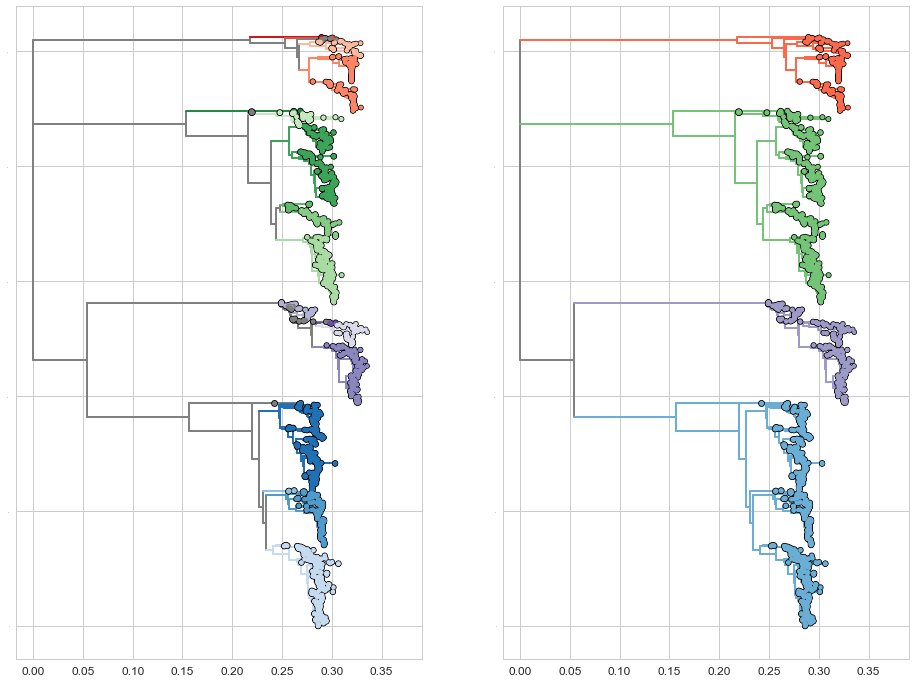

In [14]:
def plot_tree(tree, labels=False, colorby='genotype'):
    branchWidth=2 ## default branch width
    ll = tree

    plt.yticks(size=0)
    
    for k in ll.Objects: ## iterate over objects in tree
        x=k.x ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
        c = colors[k.traits[colorby]] if k.traits.has_key(colorby) else 'gray'
            
        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            s=50 ## tip size can be fixed
            s=50-30*k.height/ll.treeHeight
            
            plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
                        
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            plt.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
            
        plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    x0,x1 = plt.xlim()
    plt.xlim((x0, x1*1.1))
    
def plot_subtrees(tree, labels = False, serotype_mrcas=[]):
    sns.set(style='whitegrid', font_scale=1.3)
    figure = plt.figure(figsize=(10,50))
    serotypes = ['DENV1', 'DENV2', 'DENV3', 'DENV4']
    serotype_tips = { sero: [k for k in tree.Objects if k.branchType=='leaf' and k.numName.startswith(sero)] for sero in serotypes}
    
    if serotype_mrcas == []:
        for sero in serotypes:
            try:
                serotype_mrcas.append((sero, tree.commonAncestor(serotype_tips[sero], numName=True)))
            except Exception as e:
                print sero
                print e
                continue
    
    for i, (serotype, mrca) in enumerate(serotype_mrcas, start=1):
        plt.subplot(4, 1,i)
        subtree = tree.subtree(mrca)
        plot_tree(subtree, labels=labels)
    plt.tight_layout()
    plt.show()
    
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,12))
plt.sca(axes[0])
plot_tree(tree, colorby='genotype')
plt.sca(axes[1])
plot_tree(tree, colorby='serotype')
plt.show()

In [20]:
def normalize_frequencies_by_timepoint(frequencies):
    ''' Normalize each row so that the sum of all frequencies at a single timepoint = 1'''
    def normalize(row):
        total = row.sum()
        if np.isnan(total) or total == 0:
            return row
        else:
            return row.map( lambda x: x / total)

    if isinstance(frequencies, dict):
        frequencies = pd.DataFrame(frequencies)
        normalized_frequencies = frequencies.apply(normalize, axis=1)
        return normalized_frequencies.to_dict()

    else:
        normalized_frequencies = frequencies.apply(normalize, axis=1)
        return normalized_frequencies

def load_all_frequencies(mrcas, path):
    '''
    {'south_america': 
            {0: [ 0.1, 0.4, 0.23, ....]},
        }, 
    'pivots': [1900, 1901, ...]
    'genotypes': set('DENV2_AMERICAN', ...)}
    '''    
    raw_frequencies = json.load(open(path, 'r')) ## {'southeast_asia_clade:179':[0.1, 0.23, ...]}
    pivots = raw_frequencies.pop('pivots') # [1917., 1918., ...]
    
    regional_clade_frequencies = defaultdict(dict) ## {'global': {'0': [0.1, 0.23, ...] } }
    for label, freqs in raw_frequencies.items():
        if 'clade:' not in label: #south_america_II, africa_denv4_II
            split_label = label.split('_')

            if 'DENV' in label:
                region = '_'.join(split_label[:-2])
                clade = '_'.join(split_label[-2:])
            else:
                region = '_'.join(split_label[:-1])
                clade = '_'.join(split_label[-1:])
            try:
                clade = mrcas[clade].traits['clade']
            except:
                continue
                
        else: # 'global_clade:0'
            region, clade = label.split('_clade:')
            
        clade = int(clade) # the tree uses integers for clade indices
        regional_clade_frequencies[region][clade] = freqs 
        
    return {'frequencies': dict(regional_clade_frequencies), 
            'pivots': pivots }

def get_genotype_frequencies(mrcas, frequencies):
    genotype_frequencies = defaultdict(dict)
    
    for genotype, mrca in mrcas.items():
        if 'SYLVATIC' in genotype.upper():
            continue
        if isinstance(mrca, bt.node):
            mrca_clade = mrca.traits['clade']
            genotype_frequencies[genotype] = frequencies[mrca_clade] 
            
        elif isinstance(mrca, list):
            mrca_clades = [m.traits['clade'] for m in mrca]
            clade_frequencies = [frequencies[c] for c in mrca_clades]
            total_genotype_frequency = [sum(i) for i in zip(*clade_frequencies)]
            genotype_frequencies[genotype] = total_genotype_frequency
            
    return dict(genotype_frequencies)

def make_dataframe(genotype_frequencies, pivots, mindate=1970.):
    ''' dataframe with genotypes as columns, pivots as index, region-specific frequencies as values'''
    df = pd.DataFrame(genotype_frequencies, index=pivots)
    df = df.loc[df.index[df.index >= mindate]]
    return normalize_frequencies_by_timepoint(df)

In [21]:
tmp = load_all_frequencies(mrcas, freqs_path)
pivots = tmp['pivots']
genotype_frequencies = {region: get_genotype_frequencies(mrcas, freqs) for region, freqs in tmp['frequencies'].items()}
genotype_frequencies = {region: make_dataframe(freqs, pivots) for region, freqs in genotype_frequencies.items()}

serotype_frequencies = {region: get_genotype_frequencies(serotype_mrcas, freqs) for region, freqs in tmp['frequencies'].items()}
serotype_frequencies = {region: make_dataframe(freqs, pivots) for region, freqs in serotype_frequencies.items()}


In [22]:
print genotype_frequencies['southeast_asia'].head()

              DENV1_I  DENV1_II  DENV1_IV   DENV1_V  DENV2_AMERICAN  \
1970.166667  0.156094  0.168868  0.009272  0.223206        0.003436   
1970.416667  0.158221  0.152535  0.009400  0.264423        0.003034   
1970.666667  0.158198  0.135819  0.009398  0.309048        0.002618   
1970.916667  0.158495  0.121058  0.009415  0.351809        0.002203   
1971.166667  0.149861  0.101695  0.008903  0.407168        0.001807   

             DENV2_ASIANAMERICAN  DENV2_ASIANI  DENV2_ASIANII  \
1970.166667             0.014855      0.139082       0.012455   
1970.416667             0.013115      0.122792       0.010995   
1970.666667             0.011322      0.105993       0.009492   
1970.916667             0.009523      0.089162       0.007984   
1971.166667             0.007814      0.073169       0.006553   

             DENV2_COSMOPOLITAN   DENV3_I  DENV3_II  DENV3_III   DENV3_V  \
1970.166667            0.011291  0.061779  0.089590   0.016455  0.032702   
1970.416667            0.00996

In [25]:
def plot_region_frequencies(freqs, title, date_range = None, pivots=pivots):
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Frequency')

    if date_range:
        pivots = [i for i in pivots if i > date_range[0] and i < date_range[1]]
        freqs = freqs.ix[pivots]
    
    for genotype, freqs in freqs.iteritems():
        plt.plot(pivots, freqs, color=colors[genotype], label=genotype)   
    
def plot_frequencies_and_tree(save=False, ofilename = None, colorby='genotype', frequencies=genotype_frequencies,
                              title='Dengue Genotypes'):
    sns.set(style='whitegrid', font_scale = 1.3)
    fig = plt.figure(figsize=(11,8.5))
    gs = gridspec.GridSpec(3,3, width_ratios=[1,1,2], )
    
    globe = plt.subplot(gs[0, :-1])
    plot_region_frequencies(frequencies['global'], 'Global', date_range=[1985., 2015.])
    plt.legend(loc=(2.,-2.), title=title, fontsize='medium')
    globe.set_ylim([0, 1])

    if len(frequencies.keys()) > 1:
        south_america = plt.subplot(gs[1,:-1])
        plot_region_frequencies(frequencies['south_america'], 'South America',date_range=[1985., 2015.])
        south_america.set_ylim([0, 1])

        southeast_asia = plt.subplot(gs[2, :-1])
        plot_region_frequencies(frequencies['southeast_asia'], 'Southeast Asia', date_range=[1985., 2014.])
        southeast_asia.set_ylim([0, 1])
        
    sns.set(style = 'white', font_scale = 1.3)
    treeplot = plt.subplot(gs[:,-1])
    plot_tree(tree, colorby=colorby)
        
    plt.tight_layout()
    
    if save==True:
        plt.savefig(out_path+ofilename, dpi=400, bbox_inches='tight')
    else:    
        plt.show()

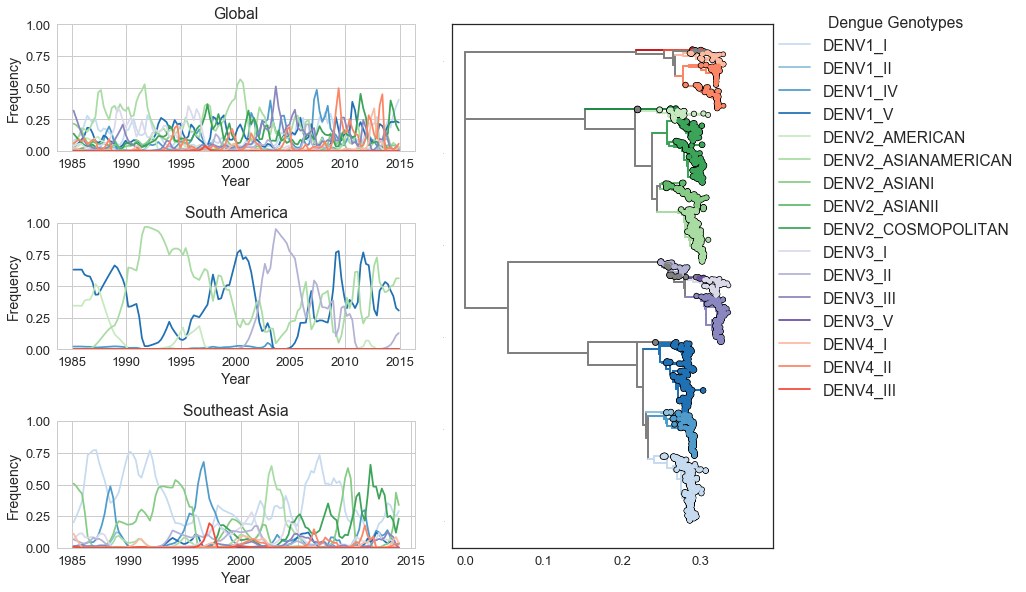

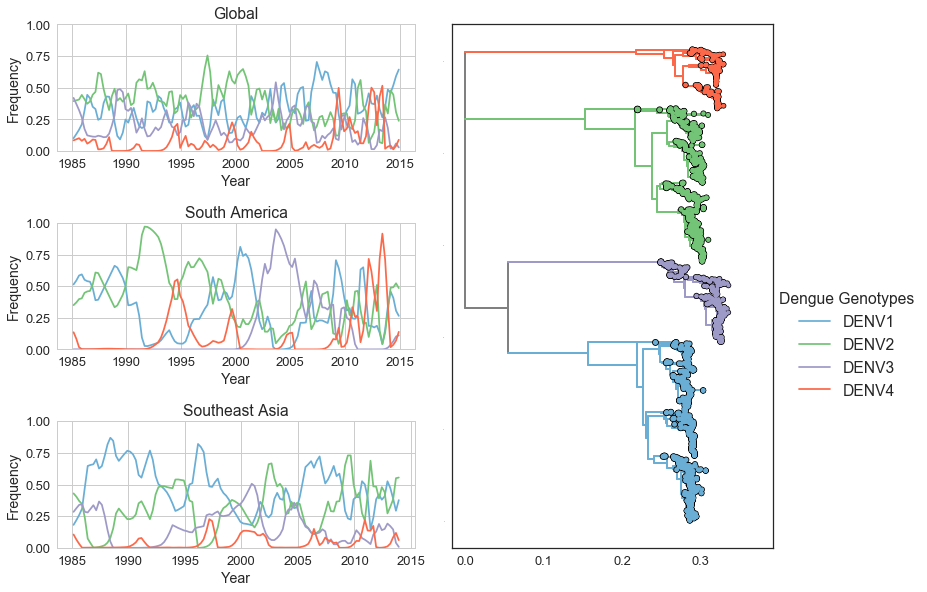

In [42]:
def export(out_path=out_path, tree=tree, frequency_attr = 'genotype', frequencies=genotype_frequencies):
    plot_frequencies_and_tree(save=True, colorby=frequency_attr, frequencies=frequencies, ofilename=out_path+frequency_attr+'_frequencies_tree.png')
    tree_string = tree.toString(traits=['clade', 'reference_genotype', 'genotype', 'serotype'], numName=True, nexus=True)
    open(out_path+'annotated_tree.nexus', 'w').write(tree_string)

    if len(frequencies) == 1:
        frequencies.values()[0].to_csv(out_path+'%s_frequencies.csv'%frequency_attr)
    else:
        for region, df in frequencies.items():
            df.to_csv(out_path+region+'%s_frequencies.csv'%frequency_attr)

export(frequency_attr = 'genotype', frequencies=genotype_frequencies)
export(frequency_attr = 'serotype', frequencies=serotype_frequencies)

In [37]:
def get_dTiter(k1, k2, tree):

    if k1 not in tree.Objects or k2 not in tree.Objects:
        if type(k1) == list:
            k1 = min(k1)
        if type(k2) == list:
            k2 = min(k2)
        k1 = [k for k in tree.Objects if k.traits['clade']==k1.traits['clade']][0]
        k2 = [k for k in tree.Objects if k.traits['clade']==k2.traits['clade']][0]
    k1_trace = []
    k2_trace = []
    k = k1 ## Trace from the node 1 to the root (in order)
    while k.index != 'Root':
        k1_trace.append(k)
        k = k.parent
    k = k2 ## Start tracing from node2 to the root; break when we find the first node that's shared along node1's path
    while k not in k1_trace:
        k2_trace.append(k)
        k = k.parent
    else: # first shared node is the Most Recent Common Ancestor (MRCA)
        mrca = k
    shared_k1_trace = k1_trace[:k1_trace.index(mrca)]
    k2_trace.reverse() # walk back down from the mrca, so the path is unidirectional (doesn't matter, but makes my type-A brain happy)
    total_trace = [] # verbose for clarity
    total_trace += shared_k1_trace
    total_trace += k2_trace

    dTiter = sum([k.traits['dTiter'] for k in total_trace]) # sum up dTiter values along the path between clade1 and clade2    
    return dTiter

all_effects_tree = tree
json_translation = {
        'name': 'strain',
        'height': 'xvalue',
    }
# interserotype_effects_tree = bt.loadJSON('../data/augur-output/dengue_interseroBranchEffects_tree.json', json_translation) ## baltic Tree object

all_effects_Dij = { tuple(sorted([i,j])) : get_dTiter(mrcas[i], mrcas[j], all_effects_tree) 
                  for (i,j) in combinations(mrcas.keys(), 2)}

all_effects_Dij.update({ tuple(sorted([i,j])) : get_dTiter(serotype_mrcas[i], serotype_mrcas[j], all_effects_tree) 
                  for (i,j) in combinations(serotype_mrcas.keys(), 2)})

interserotype_effects_Dij = { tuple(sorted([i,j])) : get_dTiter(mrcas[i], mrcas[j], interserotype_effects_tree) 
                  for (i,j) in combinations(mrcas.keys(), 2)}

interserotype_effects_Dij.update({ tuple(sorted([i,j])) : get_dTiter(serotype_mrcas[i], serotype_mrcas[j], interserotype_effects_tree) 
                  for (i,j) in combinations(serotype_mrcas.keys(), 2)})

In [41]:
pd.Series(all_effects_Dij).reset_index().to_csv(out_path+'all_effects_Dij.csv', header=False, index=False)
pd.Series(interserotype_effects_Dij).reset_index().to_csv(out_path+'interserotype_effects_Dij.csv', header=False, index=False)
